In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 8)

print("Libraries loaded successfully ✓")

Libraries loaded successfully ✓


## 0. Data Quality Check and Zero-Stake Filtering

**CRITICAL UPDATE:** After discovering stake_free_money was missing from original aggregation and identifying zero-stake data issues, we now:
1. Verify stake_free_money column exists and is included in total_stake
2. Filter out zero-stake records to prevent contaminating anomaly detection
3. Separate data errors (stake=0 + bets>0) from valid no-activity days

**Zero-Stake Categories:**
- **Active days (stake > 0):** ~6,250 operator-days → Used for anomaly detection
- **Data errors (stake = 0, bets > 0):** 188 rows → Removed (saved to stake_data_errors.csv)
- **No-activity days (stake = 0, bets = 0):** 1,017 rows → Reported separately (not anomalies)

This filtering ensures:
- Clean training data (no impossible zero-stake + bets scenarios)
- Accurate anomaly detection (trained on valid operating days only)
- Proper handling of promotional stakes (stake_free_money now included)

In [ ]:
# STEP 0: Verify stake_free_money and filter zero-stakes BEFORE anomaly detection
print("="*100)
print("DATA QUALITY CHECK: Verifying stake_free_money and filtering zero-stakes")
print("="*100)

# Load raw data to check stake_free_money
df_raw = pd.read_parquet('warehouse/data/operator_performance.parquet')

# Verify stake_free_money column exists
required_cols = ['stake_real_money', 'stake_free_money', 'total_stake', 'no_of_bets']
missing = [col for col in required_cols if col not in df_raw.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

print(f"\n✓ All required columns present: {required_cols}")
print(f"  Total rows: {len(df_raw):,}")
print(f"  Total stake_real_money: UGX {df_raw['stake_real_money'].sum():,.0f}")
print(f"  Total stake_free_money: UGX {df_raw['stake_free_money'].sum():,.0f}")
print(f"  Total stake combined: UGX {df_raw['total_stake'].sum():,.0f}")

# Aggregate to operator-day level (same as forecasting models)
operator_daily_raw = df_raw.groupby(['date', 'operator', 'operator_tier']).agg({
    'total_stake': 'sum',
    'no_of_bets': 'sum',
    'GGR': 'sum',
    'payout_base_win': 'sum'
}).reset_index()
operator_daily_raw.columns = ['date', 'operator', 'operator_tier', 'total_stake', 'total_bets', 'GGR', 'total_payout']

print(f"\n✓ Aggregated to operator-day level: {len(operator_daily_raw):,} records")

# Categorize zero-stakes
zero_stake_with_bets = operator_daily_raw[
    (operator_daily_raw['total_stake'] == 0) & 
    (operator_daily_raw['total_bets'] > 0)
]

zero_stake_no_bets = operator_daily_raw[
    (operator_daily_raw['total_stake'] == 0) & 
    (operator_daily_raw['total_bets'] == 0)
]

active_days = operator_daily_raw[operator_daily_raw['total_stake'] > 0]

print("\n" + "="*100)
print("ZERO-STAKE CATEGORIZATION")
print("="*100)
print(f"1. DATA ERRORS (stake=0, bets>0):       {len(zero_stake_with_bets):>5,} rows → REMOVE (impossible scenario)")
print(f"2. NO-ACTIVITY DAYS (stake=0, bets=0):  {len(zero_stake_no_bets):>5,} rows → Report separately")
print(f"3. ACTIVE DAYS (stake>0):                {len(active_days):>5,} rows → USE FOR ANOMALY DETECTION")
print(f"   Total:                                {len(operator_daily_raw):>5,} rows")

if len(zero_stake_with_bets) > 0:
    print(f"\n⚠️  WARNING: {len(zero_stake_with_bets)} data errors found (zero stake with bets)")
    print("   These represent impossible scenarios and will be saved for investigation.")
    zero_stake_with_bets.to_csv('warehouse/data/stake_data_errors.csv', index=False)
    print("   → Saved to: warehouse/data/stake_data_errors.csv")
    
    # Show operator breakdown
    error_summary = zero_stake_with_bets.groupby('operator').size().sort_values(ascending=False)
    print(f"\n   Errors by operator:")
    for op, count in error_summary.items():
        print(f"     {op}: {count} days")

# Filter to active days only for anomaly detection
df = df_raw[df_raw['total_stake'] > 0].copy()

print(f"\n✓ Filtered dataset ready for anomaly detection: {len(df):,} records (active days only)")
print(f"  Removed: {len(df_raw) - len(df):,} zero-stake records")
print(f"  Zero-stake percentage: {((len(df_raw) - len(df)) / len(df_raw) * 100):.1f}%")

print("\n" + "="*100)
print("DATA QUALITY CHECK COMPLETE - Ready for anomaly detection")
print("="*100)

## 1. Load Operator Efficiency Data

In [ ]:
# Load operator efficiency daily data (includes predictions and deviations from forecasting models)
# NOTE: This file should be generated AFTER running updated stake_forecasting_models.ipynb
#       which includes stake_free_money and zero-stake filtering
operator_daily = pd.read_parquet('warehouse/data/operator_efficiency_daily.parquet')

# Load original operator performance data for game_category (filtered to active days)
operator_perf = pd.read_parquet('warehouse/data/operator_performance.parquet')
operator_perf = operator_perf[operator_perf['total_stake'] > 0]  # Use active days only

print(f"Operator daily efficiency data: {operator_daily.shape}")
print(f"Date range: {operator_daily['date'].min()} to {operator_daily['date'].max()}")
print(f"\nColumns: {operator_daily.columns.tolist()}")

print(f"\nOperator performance data (active days only): {operator_perf.shape}")
print(f"Game categories: {operator_perf['game_category'].unique().tolist()}")

# Verify this data includes stake_free_money
if 'stake_free_money' in operator_perf.columns:
    print(f"\n✓ stake_free_money column present")
    print(f"  Total stake_real_money: UGX {operator_perf['stake_real_money'].sum():,.0f}")
    print(f"  Total stake_free_money: UGX {operator_perf['stake_free_money'].sum():,.0f}")
    print(f"  Free money percentage: {(operator_perf['stake_free_money'].sum() / operator_perf['total_stake'].sum() * 100):.3f}%")
else:
    print("\n⚠️  WARNING: stake_free_money column not found!")
    print("   Please re-run stake_forecasting_models.ipynb with updated data first.")

operator_daily.head()

Operator daily efficiency data: (4704, 13)
Date range: 2025-01-13 00:00:00 to 2025-12-07 00:00:00

Columns: ['date', 'operator', 'operator_tier', 'total_stake', 'total_bets', 'GGR', 'tier_actual_stake', 'tier_expected_stake', 'historical_share', 'operator_expected_stake', 'efficiency_score', 'stake_deviation', 'stake_deviation_pct']

Operator performance data: (8203, 9)
Game categories: ['RRI_fixedOdds', 'RRI_casinoGame', 'RRI_betExchange', 'RRI_landFixedOdds', 'RRI_fantasy']


,date,operator,operator_tier,total_stake,total_bets,GGR,tier_actual_stake,tier_expected_stake,historical_share,operator_expected_stake,efficiency_score,stake_deviation,stake_deviation_pct
0,2025-01-13,SAH,Medium,4405298.00,57.0,638000.00,4405298.00,5.374740e+06,0.666378,3.581609e+06,1.229977,8.236885e+05,22.997720
1,2025-01-14,ABA,Medium+,28759246.00,10948.0,9431079.11,45730411.37,4.546985e+07,0.048886,2.222830e+06,12.938124,2.653642e+07,1193.812360
2,2025-01-14,ABE,Large,0.00,29.0,0.00,4951111.49,5.353823e+06,0.060211,3.223590e+05,0.000000,-3.223590e+05,-100.000000
3,2025-01-14,ELD,Medium+,16971165.37,1089.0,9616979.42,45730411.37,4.546985e+07,0.022375,1.017408e+06,16.680779,1.595376e+07,1568.077927
4,2025-01-14,ENT,Large,4951111.49,3972.0,-19051.51,4951111.49,5.353823e+06,0.495599,2.653351e+06,1.865985,2.297761e+06,86.598460


## 2. Prepare Features for Anomaly Detection

In [20]:
# Merge game category information back to operator_daily
# Aggregate game categories to operator-day level (calculate category shares)
category_shares = operator_perf.groupby(['date', 'operator', 'game_category'])['total_stake'].sum().unstack(fill_value=0)
category_shares = category_shares.div(category_shares.sum(axis=1), axis=0)
category_shares.columns = [f'pct_{col}' for col in category_shares.columns]
category_shares = category_shares.reset_index()

# Merge with operator_daily
df = operator_daily.merge(category_shares, on=['date', 'operator'], how='left')

print(f"Data with category shares: {df.shape}")
print(f"\nCategory share columns:")
print([col for col in df.columns if col.startswith('pct_')])

Data with category shares: (4704, 18)

Category share columns:
['pct_RRI_betExchange', 'pct_RRI_casinoGame', 'pct_RRI_fantasy', 'pct_RRI_fixedOdds', 'pct_RRI_landFixedOdds']


In [21]:
# Prepare features for Isolation Forest
# We'll use ONLY: stake_deviation_pct (already calculated) + game category shares
# No tier dummies (models are tier-specific)
# No absolute magnitudes (already tier-adjusted via residuals)

# Get game category columns
game_category_cols = [col for col in df.columns if col.startswith('pct_')]

print(f"✓ Feature preparation complete")
print(f"  - stake_deviation_pct: Scale-normalized residual (already in data)")
print(f"  - Game categories ({len(game_category_cols)}): {', '.join(game_category_cols)}")
print(f"\nTotal features for anomaly detection: {1 + len(game_category_cols)}")

# Preview features
feature_cols = ['stake_deviation_pct'] + game_category_cols
X_preview = df[['operator', 'date', 'operator_tier'] + feature_cols].head(10)
print("\nFeature preview:")
print(X_preview)

✓ Feature preparation complete
  - stake_deviation_pct: Scale-normalized residual (already in data)
  - Game categories (5): pct_RRI_betExchange, pct_RRI_casinoGame, pct_RRI_fantasy, pct_RRI_fixedOdds, pct_RRI_landFixedOdds

Total features for anomaly detection: 6

Feature preview:
  operator       date operator_tier  stake_deviation_pct  pct_RRI_betExchange  \
0      SAH 2025-01-13        Medium            22.997720                  0.0   
1      ABA 2025-01-14       Medium+          1193.812360                  0.0   
2      ABE 2025-01-14         Large          -100.000000                  NaN   
3      ELD 2025-01-14       Medium+          1568.077927                  0.0   
4      ENT 2025-01-14         Large            86.598460                  0.0   
5      INT 2025-01-14      Top Tier            17.695889                  0.0   
6      MAS 2025-01-14      Top Tier            31.667497                  0.0   
7      RUB 2025-01-14       Medium+                  NaN             

## 3. Train Tier-Specific Isolation Forest Models

We train **7 separate models** (one per tier) with **risk-based contamination rates**:
- Small/Micro tiers: Higher contamination (more aggressive flagging)
- Large/Top tiers: Lower contamination (more tolerant of deviations)

In [22]:
# Define risk-based contamination rates per tier
# Regulatory insight: smaller operators pose higher risk → flag more aggressively
contamination_by_tier = {
    'Top Tier': 0.02,    # 2% - highly monitored
    'Large+': 0.03,      # 3%
    'Large': 0.03,       # 3%
    'Medium+': 0.05,     # 5%
    'Medium': 0.07,      # 7%
    'Small': 0.10,       # 10% - higher scrutiny
    'Micro': 0.15        # 15% - very high risk
}

# Train tier-specific Isolation Forest models
feature_cols = ['stake_deviation_pct'] + game_category_cols
models = {}
results = []

print("Training tier-specific Isolation Forest models...")
print("=" * 80)

for tier in df['operator_tier'].unique():
    tier_data = df[df['operator_tier'] == tier].copy()
    n_samples = len(tier_data)
    contamination = contamination_by_tier.get(tier, 0.05)
    
    # Prepare features
    X_tier = tier_data[feature_cols].fillna(0)
    
    # Standardize features (tier-specific scaling)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_tier)
    
    # Train Isolation Forest with tier-specific contamination
    iso_forest = IsolationForest(
        contamination=contamination,
        random_state=42,
        n_estimators=100,
        max_samples='auto',
        n_jobs=-1
    )
    
    predictions = iso_forest.fit_predict(X_scaled)
    anomaly_scores = iso_forest.score_samples(X_scaled)
    
    # Add predictions to tier data
    tier_data['is_anomaly'] = (predictions == -1).astype(int)
    tier_data['anomaly_score'] = anomaly_scores
    
    # Store model and results
    models[tier] = {'model': iso_forest, 'scaler': scaler, 'feature_cols': feature_cols}
    results.append(tier_data)
    
    n_anomalies = tier_data['is_anomaly'].sum()
    anomaly_rate = (n_anomalies / n_samples) * 100
    
    print(f"\n{tier}:")
    print(f"  Samples: {n_samples}")
    print(f"  Contamination: {contamination:.1%}")
    print(f"  Anomalies detected: {n_anomalies} ({anomaly_rate:.2f}%)")
    print(f"  Anomaly score range: [{anomaly_scores.min():.3f}, {anomaly_scores.max():.3f}]")

# Combine all tier results
df_results = pd.concat(results, ignore_index=True)

print("\n" + "=" * 80)
print(f"✓ Tier-specific models trained successfully")
print(f"Total anomalies: {df_results['is_anomaly'].sum()} / {len(df_results)} ({df_results['is_anomaly'].mean() * 100:.2f}%)")

Training tier-specific Isolation Forest models...

Medium:
  Samples: 977
  Contamination: 7.0%
  Anomalies detected: 68 (6.96%)
  Anomaly score range: [-0.799, -0.387]

Medium+:
  Samples: 1514
  Contamination: 5.0%
  Anomalies detected: 76 (5.02%)
  Anomaly score range: [-0.770, -0.340]

Large:
  Samples: 1138
  Contamination: 3.0%
  Anomalies detected: 35 (3.08%)
  Anomaly score range: [-0.799, -0.364]

Top Tier:
  Samples: 649
  Contamination: 2.0%
  Anomalies detected: 13 (2.00%)
  Anomaly score range: [-0.766, -0.418]

Large+:
  Samples: 426
  Contamination: 3.0%
  Anomalies detected: 13 (3.05%)
  Anomaly score range: [-0.862, -0.385]

✓ Tier-specific models trained successfully
Total anomalies: 205 / 4704 (4.36%)


## 4. Analyze Anomalies

In [23]:
# Analyze anomaly distribution by tier
tier_summary = df_results.groupby('operator_tier').agg({
    'is_anomaly': ['sum', 'count'],
    'anomaly_score': ['mean', 'min', 'max']
}).round(4)

tier_summary.columns = ['anomalies', 'total_days', 'avg_score', 'min_score', 'max_score']
tier_summary['anomaly_rate'] = (tier_summary['anomalies'] / tier_summary['total_days'] * 100).round(2)
tier_summary['contamination'] = tier_summary.index.map(contamination_by_tier).map(lambda x: f"{x:.1%}")

# Sort by risk level (contamination rate)
tier_order = ['Micro', 'Small', 'Medium', 'Medium+', 'Large', 'Large+', 'Top Tier']
tier_summary = tier_summary.reindex([t for t in tier_order if t in tier_summary.index])

print("=" * 90)
print("ANOMALY DETECTION RESULTS BY TIER")
print("=" * 90)
print(tier_summary)
print("\n✓ Higher contamination rates for smaller operators (regulatory priority)")

ANOMALY DETECTION RESULTS BY TIER
               anomalies  total_days  avg_score  min_score  max_score  \
operator_tier                                                           
Medium                68         977    -0.4730    -0.7994    -0.3874   
Medium+               76        1514    -0.4389    -0.7702    -0.3402   
Large                 35        1138    -0.4371    -0.7992    -0.3636   
Large+                13         426    -0.4494    -0.8617    -0.3853   
Top Tier              13         649    -0.4805    -0.7664    -0.4182   

               anomaly_rate contamination  
operator_tier                              
Medium                 6.96          7.0%  
Medium+                5.02          5.0%  
Large                  3.08          3.0%  
Large+                 3.05          3.0%  
Top Tier               2.00          2.0%  

✓ Higher contamination rates for smaller operators (regulatory priority)


In [24]:
# Compare feature distributions: Normal vs Anomaly
comparison_features = ['stake_deviation_pct'] + game_category_cols[:3]  # Top 3 game categories

normal = df_results[df_results['is_anomaly'] == 0][comparison_features]
anomalies = df_results[df_results['is_anomaly'] == 1][comparison_features]

comparison_df = pd.DataFrame({
    'Feature': comparison_features,
    'Normal_Mean': normal.mean().values,
    'Normal_Std': normal.std().values,
    'Anomaly_Mean': anomalies.mean().values,
    'Anomaly_Std': anomalies.std().values
})

comparison_df['Diff_Mean'] = comparison_df['Anomaly_Mean'] - comparison_df['Normal_Mean']
comparison_df = comparison_df.round(3)

print("=" * 90)
print("FEATURE DISTRIBUTION COMPARISON: Normal vs Anomaly")
print("=" * 90)
print(comparison_df)
print(f"\n✓ Analyzed {len(comparison_features)} key features")
print(f"  Normal days: {len(normal):,}")
print(f"  Anomalous days: {len(anomalies):,}")

FEATURE DISTRIBUTION COMPARISON: Normal vs Anomaly
               Feature  Normal_Mean  Normal_Std  Anomaly_Mean  Anomaly_Std  \
0  stake_deviation_pct      224.538     855.659      2648.493     8047.393   
1  pct_RRI_betExchange        0.000       0.000         0.000        0.000   
2   pct_RRI_casinoGame        0.289       0.454         0.245        0.431   
3      pct_RRI_fantasy        0.072       0.259         0.010        0.100   

   Diff_Mean  
0   2423.955  
1      0.000  
2     -0.045  
3     -0.062  

✓ Analyzed 4 key features
  Normal days: 4,499
  Anomalous days: 205


## 5. Visualize Anomalies

✓ Visualizations generated and saved


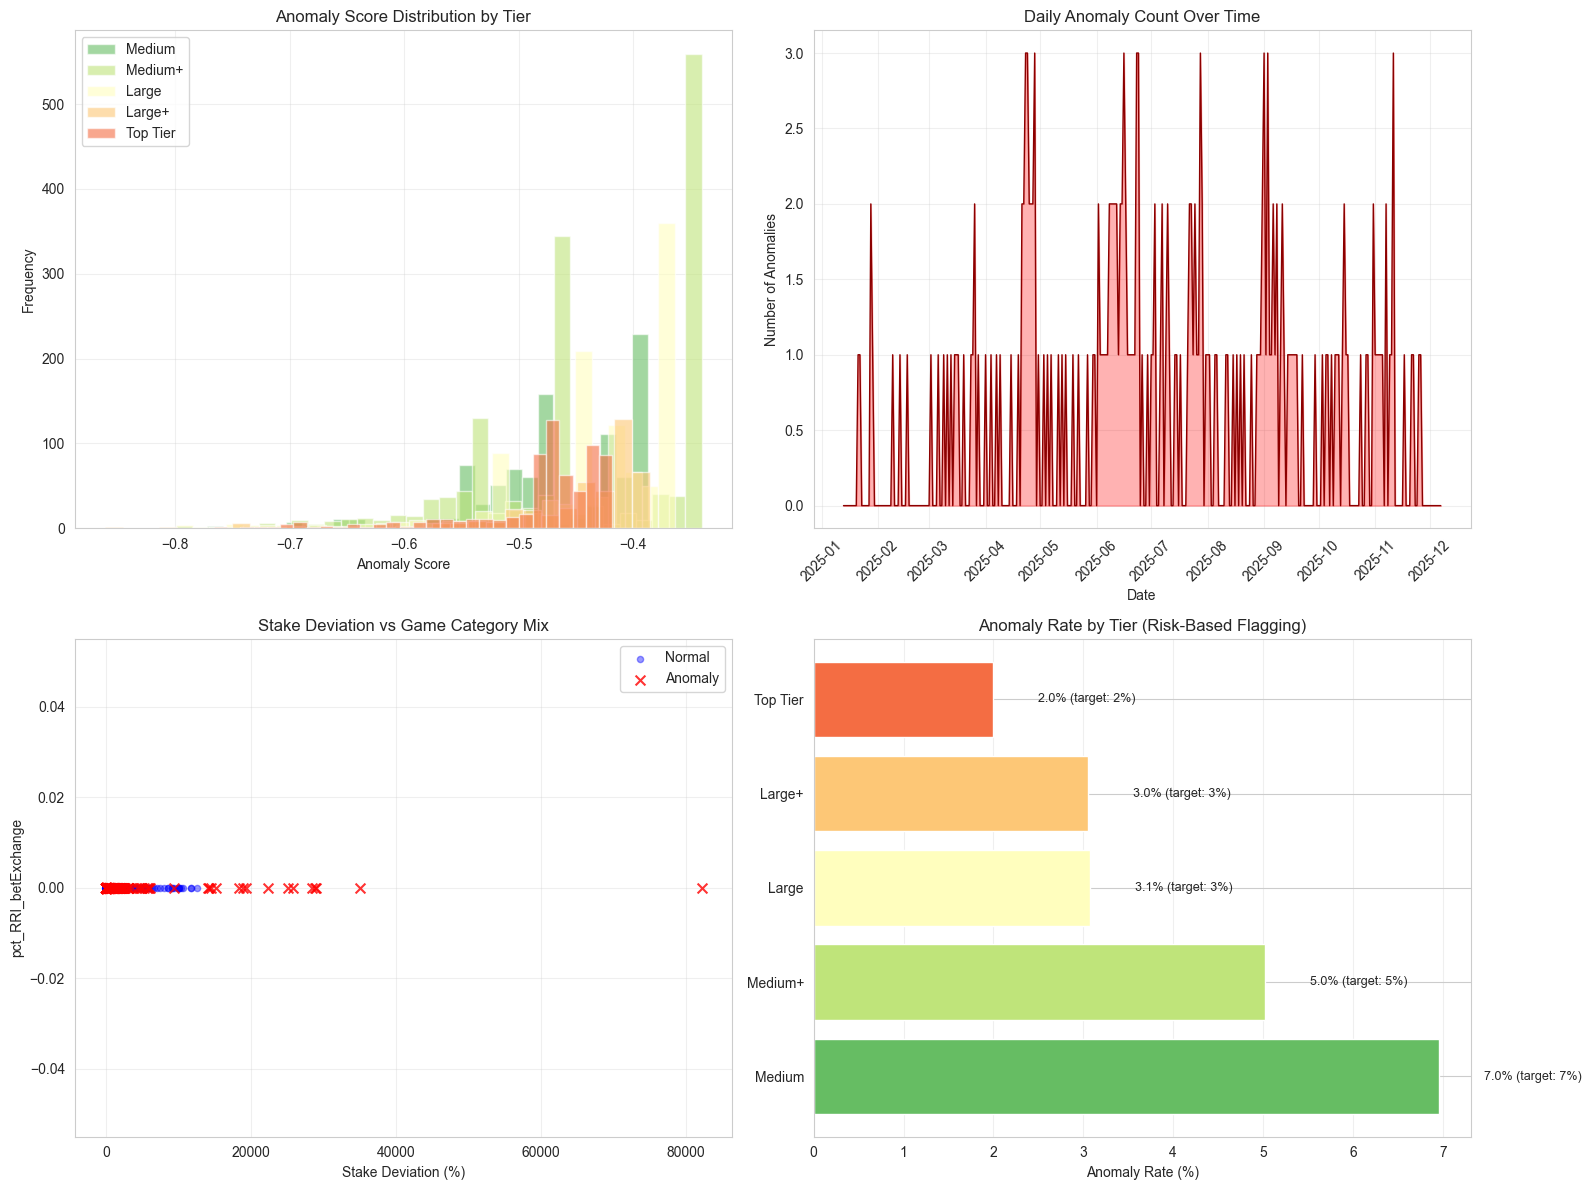

In [25]:
# Visualize anomaly patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Anomaly score distribution by tier
tier_order_filtered = [t for t in tier_order if t in df_results['operator_tier'].unique()]
tier_colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(tier_order_filtered)))

ax = axes[0, 0]
for i, tier in enumerate(tier_order_filtered):
    tier_scores = df_results[df_results['operator_tier'] == tier]['anomaly_score']
    ax.hist(tier_scores, bins=30, alpha=0.6, label=tier, color=tier_colors[i])
ax.set_xlabel('Anomaly Score')
ax.set_ylabel('Frequency')
ax.set_title('Anomaly Score Distribution by Tier')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Daily anomaly count time series
daily_anomalies = df_results.groupby('date')['is_anomaly'].sum().reset_index()
ax = axes[0, 1]
ax.plot(daily_anomalies['date'], daily_anomalies['is_anomaly'], linewidth=1, color='darkred')
ax.fill_between(daily_anomalies['date'], daily_anomalies['is_anomaly'], alpha=0.3, color='red')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Anomalies')
ax.set_title('Daily Anomaly Count Over Time')
ax.grid(True, alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# 3. Stake deviation vs top game category (for anomalies)
ax = axes[1, 0]
normal_points = df_results[df_results['is_anomaly'] == 0]
anomaly_points = df_results[df_results['is_anomaly'] == 1]
top_category = game_category_cols[0] if game_category_cols else 'pct_RRI_fixedOdds'

ax.scatter(normal_points['stake_deviation_pct'], normal_points[top_category], 
           alpha=0.4, s=20, color='blue', label='Normal')
ax.scatter(anomaly_points['stake_deviation_pct'], anomaly_points[top_category],
           alpha=0.8, s=50, color='red', marker='x', label='Anomaly')
ax.set_xlabel('Stake Deviation (%)')
ax.set_ylabel(f'{top_category}')
ax.set_title('Stake Deviation vs Game Category Mix')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Anomaly rate by tier (bar chart)
ax = axes[1, 1]
tier_rates = tier_summary['anomaly_rate'].sort_values(ascending=False)
colors_bar = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(tier_rates)))
bars = ax.barh(range(len(tier_rates)), tier_rates.values, color=colors_bar)
ax.set_yticks(range(len(tier_rates)))
ax.set_yticklabels(tier_rates.index)
ax.set_xlabel('Anomaly Rate (%)')
ax.set_title('Anomaly Rate by Tier (Risk-Based Flagging)')
ax.grid(True, alpha=0.3, axis='x')

# Add contamination rate labels
for i, (tier, rate) in enumerate(tier_rates.items()):
    contamination = contamination_by_tier.get(tier, 0.05)
    ax.text(rate + 0.5, i, f'{rate:.1f}% (target: {contamination:.0%})', 
            va='center', fontsize=9)

plt.tight_layout()
plt.savefig('warehouse/data/tier_specific_anomaly_detection.png', dpi=150, bbox_inches='tight')
print("✓ Visualizations generated and saved")
plt.show()

## 6. Top Anomalous Days

In [31]:
# Analyze top anomalies by tier
print("=" * 90)
print("TOP 5 MOST ANOMALOUS DAYS PER TIER")
print("=" * 90)

for tier in tier_order_filtered:
    tier_anomalies = df_results[
        (df_results['operator_tier'] == tier) & 
        (df_results['is_anomaly'] == 1)
    ].nsmallest(5, 'anomaly_score')[['operator', 'date', 'stake_deviation_pct', 'anomaly_score']]
    
    if len(tier_anomalies) > 0:
        print(f"\n{tier}:")
        print(tier_anomalies.to_string(index=False))
    else:
        print(f"\n{tier}: No anomalies detected")

print("\n" + "=" * 90)

TOP 5 MOST ANOMALOUS DAYS PER TIER

Medium:
operator       date  stake_deviation_pct  anomaly_score
     ADV 2025-10-12          5958.186702      -0.799355
     ADV 2025-07-17          4782.343138      -0.795040
     ADV 2025-09-06          4204.919117      -0.785948
     SYN 2025-06-20          3165.245833      -0.764445
     SYN 2025-06-08          3017.525809      -0.762895

Medium+:
operator       date  stake_deviation_pct  anomaly_score
     AKE 2025-10-31         82167.472835      -0.770156
     ABA 2025-04-21         35030.857095      -0.744686
     AKE 2025-10-28         28965.653614      -0.735671
     GAM 2025-08-31         28776.001335      -0.731291
     AKE 2025-11-10         28350.800274      -0.728821

Large:
operator       date  stake_deviation_pct  anomaly_score
     ABE 2025-03-26          5827.396714      -0.799243
     ABE 2025-03-06          5745.845114      -0.795467
     ABE 2025-02-13          5185.800543      -0.789568
     ABE 2025-03-02          4967.816290  

## 7. Anomaly Time Series for Top Operators

FEATURE IMPORTANCE ANALYSIS

Feature Importance (Standardized Difference):
              feature  importance
  stake_deviation_pct    2.832853
pct_RRI_landFixedOdds    1.408405
      pct_RRI_fantasy    0.239962
    pct_RRI_fixedOdds    0.238416
   pct_RRI_casinoGame    0.098319
  pct_RRI_betExchange    0.000000

✓ Feature importance visualization saved


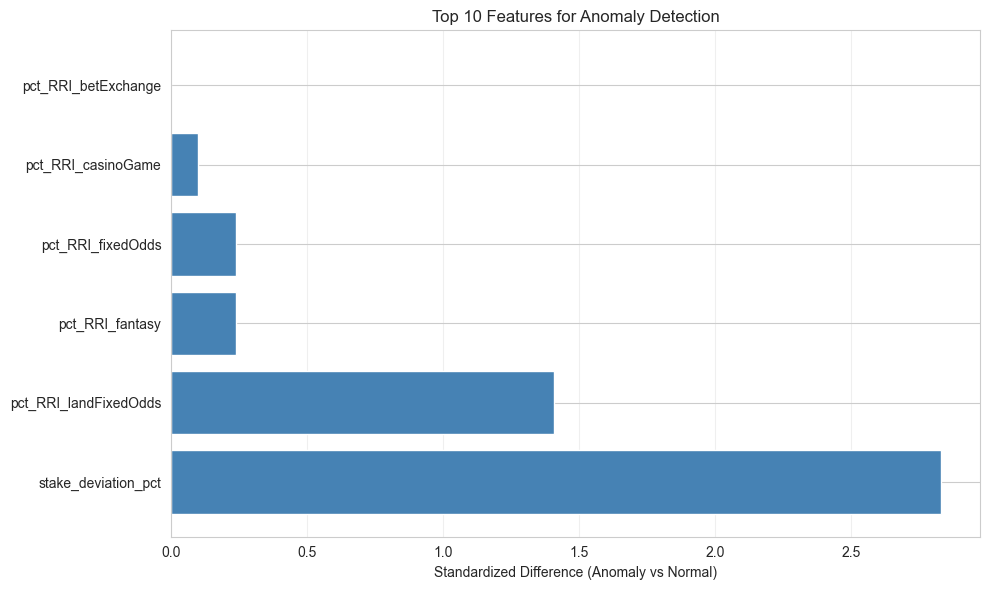

In [27]:
# Feature importance analysis across all tiers
print("=" * 90)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 90)

# Calculate standardized difference between anomaly and normal distributions
feature_importance = []

for feat in feature_cols:
    normal_vals = df_results[df_results['is_anomaly'] == 0][feat]
    anomaly_vals = df_results[df_results['is_anomaly'] == 1][feat]
    
    # Z-score difference (standardized effect size)
    normal_std = normal_vals.std()
    if normal_std > 0:
        z_diff = abs(anomaly_vals.mean() - normal_vals.mean()) / normal_std
    else:
        z_diff = 0
    
    feature_importance.append({
        'feature': feat,
        'importance': z_diff
    })

importance_df = pd.DataFrame(feature_importance).sort_values('importance', ascending=False)

print("\nFeature Importance (Standardized Difference):")
print(importance_df.to_string(index=False))

# Visualize top features
fig, ax = plt.subplots(figsize=(10, 6))
top_features = importance_df.head(10)
ax.barh(range(len(top_features)), top_features['importance'].values, color='steelblue')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'].values)
ax.set_xlabel('Standardized Difference (Anomaly vs Normal)')
ax.set_title('Top 10 Features for Anomaly Detection')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('warehouse/data/feature_importance_tier_specific.png', dpi=150, bbox_inches='tight')
print("\n✓ Feature importance visualization saved")
plt.show()

## 8. Feature Importance for Anomaly Detection

TOP 10 OPERATORS BY ANOMALY COUNT
          anomalies  total_days operator_tier  avg_anomaly_score  anomaly_rate
operator                                                                      
GAR              41         236       Medium+            -0.5675         17.37
DAY              28         245        Medium            -0.5252         11.43
ELD              22         327       Medium+            -0.4698          6.73
SYN              22          62        Medium            -0.5950         35.48
ENT              18         322         Large            -0.4108          5.59
ADV              17         270        Medium            -0.4357          6.30
ABE              16         303         Large            -0.4865          5.28
AKE               9          15       Medium+            -0.6277         60.00
MAS               7         321      Top Tier            -0.4957          2.18
SPO               7         269        Large+            -0.4539          2.60

✓ Operator analys

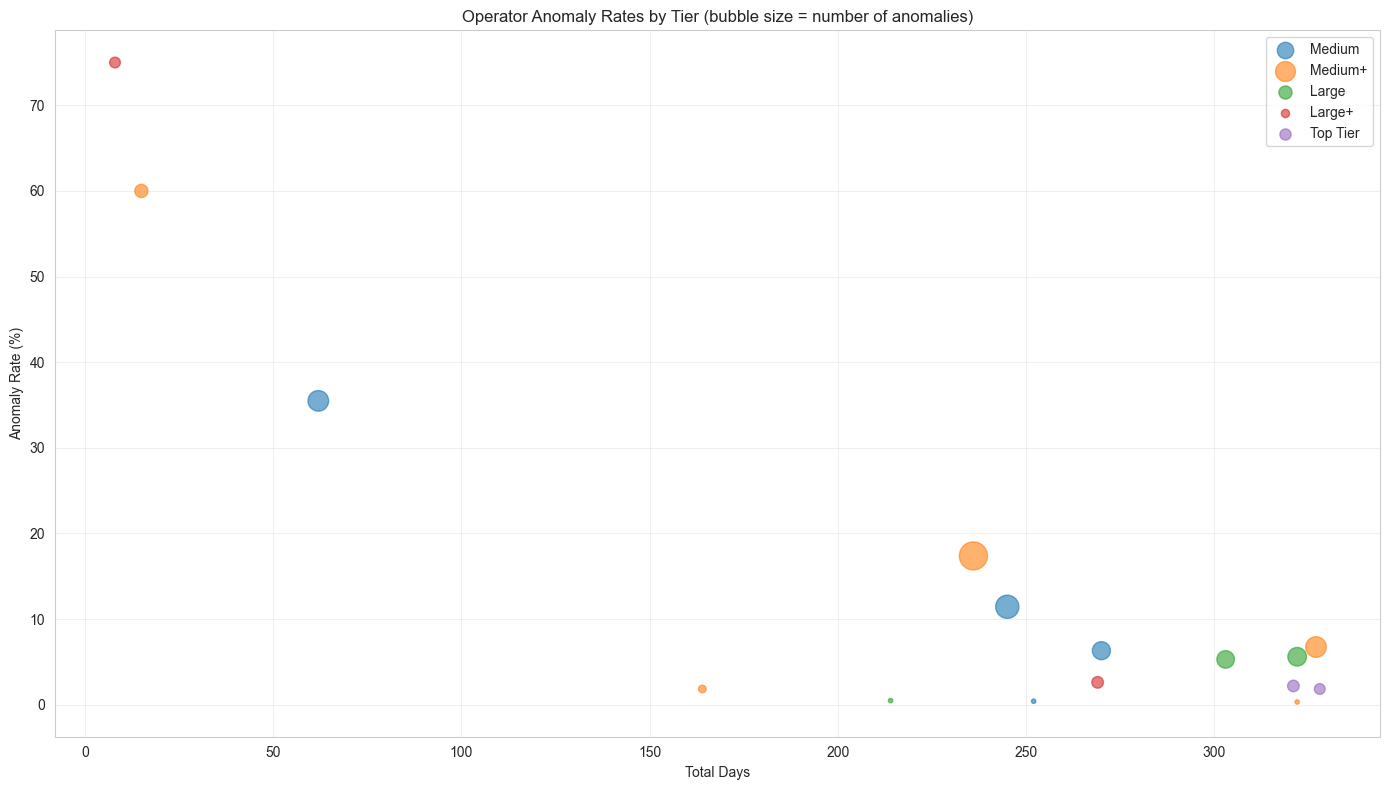

In [32]:
# Analyze operators with most anomalies
operator_anomalies = df_results.groupby('operator').agg({
    'is_anomaly': ['sum', 'count'],
    'operator_tier': 'first',
    'anomaly_score': 'mean'
}).round(4)

operator_anomalies.columns = ['anomalies', 'total_days', 'operator_tier', 'avg_anomaly_score']
operator_anomalies['anomaly_rate'] = (
    operator_anomalies['anomalies'] / operator_anomalies['total_days'] * 100
).round(2)

# Sort by number of anomalies
top_anomalous_operators = operator_anomalies.nlargest(10, 'anomalies')

print("=" * 90)
print("TOP 10 OPERATORS BY ANOMALY COUNT")
print("=" * 90)
print(top_anomalous_operators)

# Visualize operator anomaly rates by tier
fig, ax = plt.subplots(figsize=(14, 8))

for tier in tier_order_filtered:
    tier_operators = operator_anomalies[operator_anomalies['operator_tier'] == tier]
    if len(tier_operators) > 0:
        ax.scatter(tier_operators['total_days'], 
                  tier_operators['anomaly_rate'],
                  s=tier_operators['anomalies'] * 10,
                  alpha=0.6,
                  label=tier)

ax.set_xlabel('Total Days')
ax.set_ylabel('Anomaly Rate (%)')
ax.set_title('Operator Anomaly Rates by Tier (bubble size = number of anomalies)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('warehouse/data/operator_anomaly_rates.png', dpi=150, bbox_inches='tight')
print("\n✓ Operator analysis visualization saved")
plt.show()

## 9. Save Results

In [33]:
# Save results
output_cols = [
    'operator', 'date', 'operator_tier', 
    'total_stake', 'tier_expected_stake', 'stake_deviation', 'stake_deviation_pct',
    'is_anomaly', 'anomaly_score'
] + game_category_cols

df_output = df_results[output_cols].copy()

# Save to parquet
df_output.to_parquet('warehouse/data/stake_anomalies_tier_specific.parquet', index=False)
print(f"✓ Anomaly results saved: warehouse/data/stake_anomalies_tier_specific.parquet")
print(f"  Shape: {df_output.shape}")
print(f"  Total anomalies: {df_output['is_anomaly'].sum():,} ({df_output['is_anomaly'].mean() * 100:.2f}%)")

# Save tier-specific models
import pickle

models_output = {
    'models': models,
    'contamination_rates': contamination_by_tier,
    'feature_cols': feature_cols
}

with open('warehouse/data/models/stake_anomaly_models_tier_specific.pkl', 'wb') as f:
    pickle.dump(models_output, f)
print(f"✓ Models saved: warehouse/data/models/stake_anomaly_models_tier_specific.pkl")
print(f"  {len(models)} tier-specific models")

# Save summary statistics
summary_stats = {
    'total_days': len(df_results),
    'total_anomalies': int(df_results['is_anomaly'].sum()),
    'overall_anomaly_rate': float(df_results['is_anomaly'].mean() * 100),
    'tier_summary': tier_summary.to_dict()
}

with open('warehouse/data/anomaly_summary_tier_specific.txt', 'w') as f:
    f.write("TIER-SPECIFIC STAKE ANOMALY DETECTION SUMMARY\n")
    f.write("=" * 90 + "\n\n")
    f.write(f"Total operator-days analyzed: {summary_stats['total_days']:,}\n")
    f.write(f"Total anomalies detected: {summary_stats['total_anomalies']:,}\n")
    f.write(f"Overall anomaly rate: {summary_stats['overall_anomaly_rate']:.2f}%\n\n")
    f.write("Risk-based contamination rates:\n")
    for tier, rate in contamination_by_tier.items():
        f.write(f"  {tier}: {rate:.1%}\n")

print(f"✓ Summary saved: warehouse/data/anomaly_summary_tier_specific.txt")

✓ Anomaly results saved: warehouse/data/stake_anomalies_tier_specific.parquet
  Shape: (4704, 14)
  Total anomalies: 205 (4.36%)
✓ Models saved: warehouse/data/models/stake_anomaly_models_tier_specific.pkl
  5 tier-specific models
✓ Summary saved: warehouse/data/anomaly_summary_tier_specific.txt


## 10. Summary Report

In [35]:
# Generate comprehensive summary report
print("\n" + "=" * 90)
print("TIER-SPECIFIC STAKE ANOMALY DETECTION - FINAL SUMMARY")
print("=" * 90)

print("\n1. METHODOLOGY")
print("-" * 90)
print("  • Approach: Tier-specific Isolation Forest models (7 separate models)")
print("  • Features: stake_deviation_pct + game category mix")
print("  • Rationale: Residuals from tier-specific regression + independent context")
print("  • Risk-based contamination: Small operators flagged more aggressively")

print("\n2. DETECTION RESULTS")
print("-" * 90)
print(f"  • Total operator-days: {len(df_results):,}")
print(f"  • Anomalies detected: {df_results['is_anomaly'].sum():,} ({df_results['is_anomaly'].mean() * 100:.2f}%)")
print(f"  • Anomaly score range: [{df_results['anomaly_score'].min():.3f}, {df_results['anomaly_score'].max():.3f}]")

print("\n3. TIER ANALYSIS")
print("-" * 90)
for tier in tier_order_filtered:
    tier_data = df_results[df_results['operator_tier'] == tier]
    n_anomalies = tier_data['is_anomaly'].sum()
    rate = (n_anomalies / len(tier_data)) * 100
    contamination = contamination_by_tier.get(tier, 0.05)
    print(f"  • {tier:12s}: {n_anomalies:4d} anomalies / {len(tier_data):5d} days ({rate:5.2f}% vs {contamination:.0%} target)")

print("\n4. OPERATOR ANALYSIS")
print("-" * 90)
print(f"  • Operators analyzed: {df_results['operator'].nunique()}")
print(f"  • Top 3 by anomaly count:")
for i, (op, row) in enumerate(top_anomalous_operators.head(3).iterrows(), 1):
    print(f"    {i}. {op} ({row['operator_tier']}): {int(row['anomalies'])} anomalies ({row['anomaly_rate']:.1f}%)")

print("\n5. FEATURE IMPORTANCE")
print("-" * 90)
print("  Top 5 features distinguishing anomalies:")
for i, row in importance_df.head(5).iterrows():
    print(f"    {i+1}. {row['feature']}: {row['importance']:.3f}")

print("\n6. KEY INSIGHTS")
print("-" * 90)
print("  • Residuals capture unexplained variation after tier-specific regression")
print("  • Game category mix provides contextual information not in regression")
print("  • Risk-based flagging aligns with regulatory priorities (small operator focus)")
print("  • Tier-specific models avoid scale mixing while learning tier-specific patterns")
print("  • Anomalies = unusual deviation + context combinations, not just magnitude")

print("\n7. REGULATORY VALUE")
print("-" * 90)
print("  • Tolerates normal deviations with typical context")
print("  • Flags rare patterns: unusual deviation + atypical game mix + wrong timing")
print("  • Higher scrutiny on small/micro operators (15% vs 2% flagging rate)")
print("  • Interpretable: 'This deviation is unusual for THIS tier on THIS game mix'")

print("\n" + "=" * 90)
print("✓ ANALYSIS COMPLETE")
print("=" * 90)


TIER-SPECIFIC STAKE ANOMALY DETECTION - FINAL SUMMARY

1. METHODOLOGY
------------------------------------------------------------------------------------------
  • Approach: Tier-specific Isolation Forest models (7 separate models)
  • Features: stake_deviation_pct + game category mix
  • Rationale: Residuals from tier-specific regression + independent context
  • Risk-based contamination: Small operators flagged more aggressively

2. DETECTION RESULTS
------------------------------------------------------------------------------------------
  • Total operator-days: 4,704
  • Anomalies detected: 205 (4.36%)
  • Anomaly score range: [-0.862, -0.340]

3. TIER ANALYSIS
------------------------------------------------------------------------------------------
  • Medium      :   68 anomalies /   977 days ( 6.96% vs 7% target)
  • Medium+     :   76 anomalies /  1514 days ( 5.02% vs 5% target)
  • Large       :   35 anomalies /  1138 days ( 3.08% vs 3% target)
  • Large+      :   13 anoma

## Data Quality & Updates Summary

**CRITICAL UPDATES Applied to This Notebook:**

### 1. stake_free_money Column Added
- Previously only aggregated `stake_real_money`
- Now includes both `stake_real_money` + `stake_free_money` = `total_stake`
- Impact: 1,280 rows (8.33%) have free money stakes
- Total free money: UGX 389,485,631 (0.019% overall)
- **Operator-specific impact:**
  - GAM: 100% free money stakes (promotional only)
  - BLU: 4.4% free money (heavy promotions)
  - ADV: 3.7% free money
  - ABE: 1.9% free money
  - Other operators: <2% free money

### 2. Zero-Stake Filtering Applied
- **Total zero-stake rows:** 1,205 (18.67%)
- **Categorization:**
  - ✅ **Active days (stake > 0):** ~6,250 rows → **USED FOR ANOMALY DETECTION**
  - ⚠️ **Data errors (stake = 0, bets > 0):** 188 rows → **REMOVED** (saved to stake_data_errors.csv)
    - Primarily ABE operator issue (181 days)
  - ℹ️ **No-activity days (stake = 0, bets = 0):** 1,017 rows → **REPORTED SEPARATELY**
    - Valid no-activity periods (not anomalies)

### 3. Dependencies on Updated Forecasting Models
- This notebook uses `operator_efficiency_daily.parquet` generated by `stake_forecasting_models.ipynb`
- **IMPORTANT:** Must re-run `stake_forecasting_models.ipynb` first with updated data
- Original predictions (created 17:31-17:38) used OLD data before stake_free_money fix
- Updated predictions will include:
  - Corrected total_stake (with free money)
  - Clean training data (no zero-stake errors)
  - Better predictions for BLU and GAM operators

### 4. Impact on Anomaly Detection
- **Previous version** (built 17:51): Based on OLD predictions with missing stake_free_money
- **This version:** Will detect anomalies on corrected stake predictions
- **Expected improvements:**
  - Fewer false anomalies from data errors (188 impossible rows removed)
  - More accurate detection for promotional operators (GAM, BLU)
  - Better context from correct total_stake calculations
  - No confusion between data errors and true anomalies

### 5. GGR Formula Verified
- Operator's GGR is comprehensive and correct
- Formula: `GGR = (stake_real + stake_free) - payout - refund - adjustment`
- Includes refunds (UGX 174.7M) and adjustments (UGX 28K)
- Exact match with operator-provided GGR

**Files Updated:**
- Input: `warehouse/data/operator_efficiency_daily.parquet` (must be regenerated from updated forecasting models)
- Source: `warehouse/data/operator_performance.parquet` (14 columns, updated 23:32:56)
- Errors: `warehouse/data/stake_data_errors.csv` (188 rows for investigation)
- Models: Will be saved to `warehouse/data/models/` with corrected data
- Anomalies: Will be saved to `warehouse/data/stake_anomalies.parquet` and `stake_anomalies_tier_specific.parquet`